# TEST MODE

In [1]:
TEST_MODE=True

# Seeds

In [2]:
import numpy as np
import random
import os

seed=101

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)


# Imports

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
#import 

# Load data

In [4]:
train=pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sample=pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')


In [5]:
num_feats=train.select_dtypes(include='number').columns.tolist()
cat_feats=train.select_dtypes(include='object').columns.tolist()

In [6]:
#if TEST_MODE:
    #train=train[:100
    

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


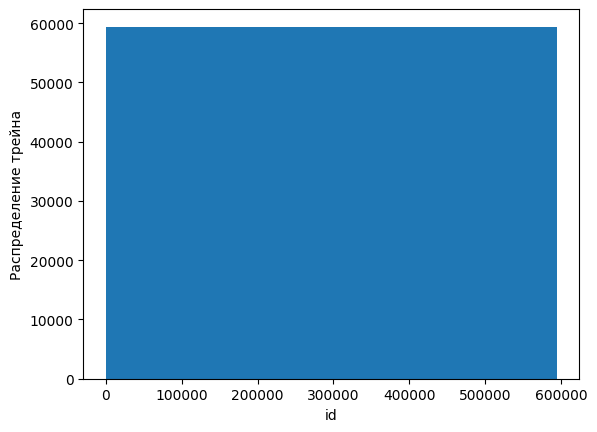

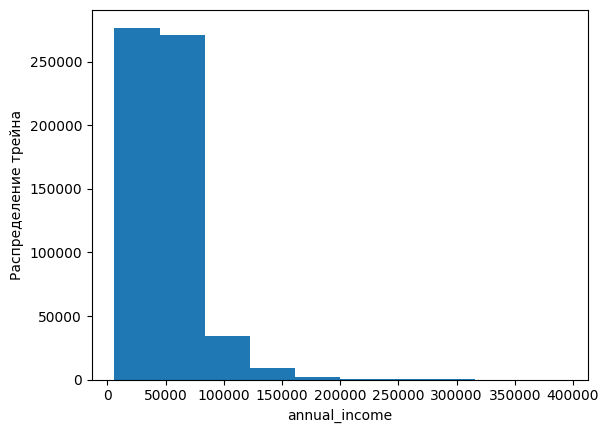

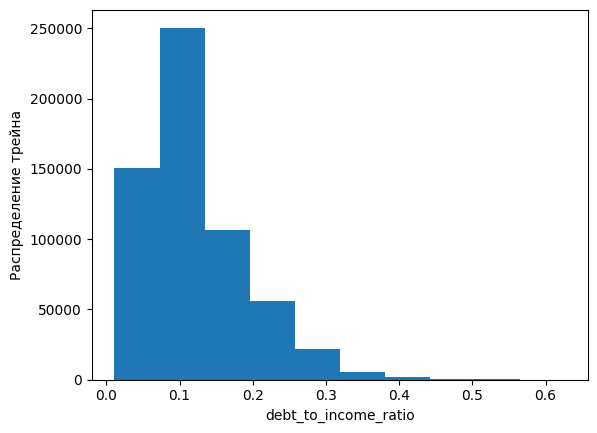

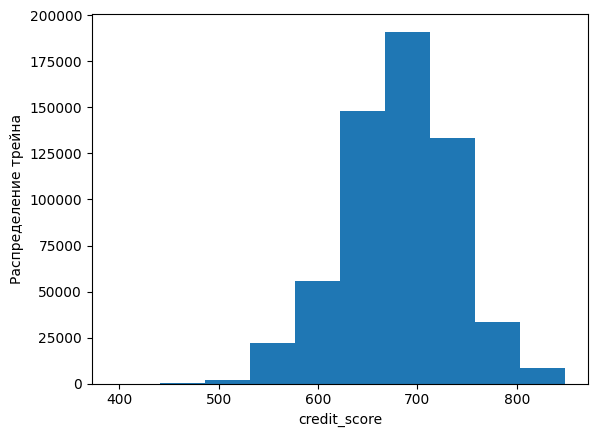

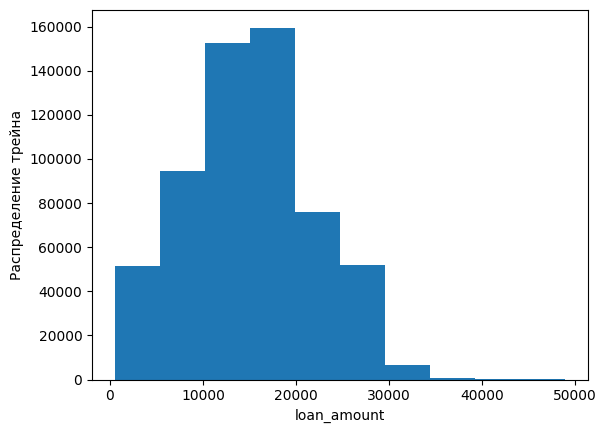

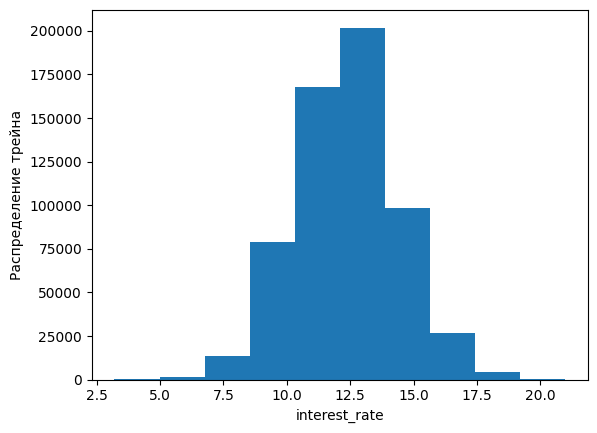

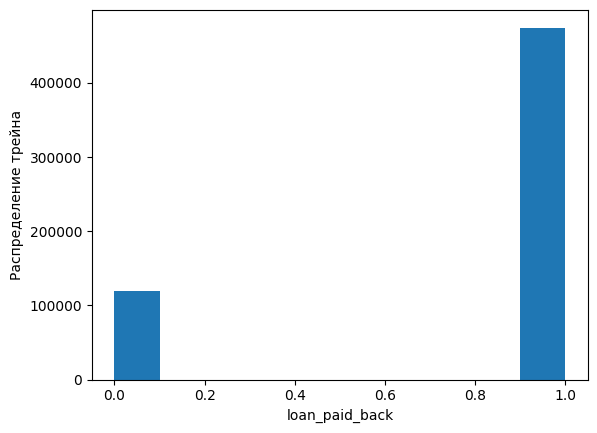

In [8]:
for col in num_feats:
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('Распределение трейна')
    plt.show()

In [9]:
'''
for col in num_feats:
    plt.hist(test[col])
    plt.xlabel(col)
    plt.ylabel('Распределение теста')
    plt.show()

'''

"\nfor col in num_feats:\n    plt.hist(test[col])\n    plt.xlabel(col)\n    plt.ylabel('Распределение теста')\n    plt.show()\n\n"

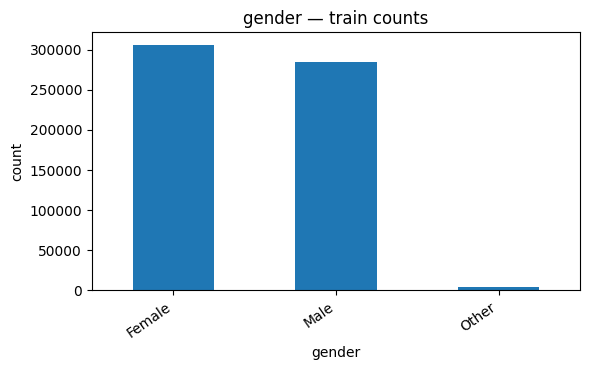

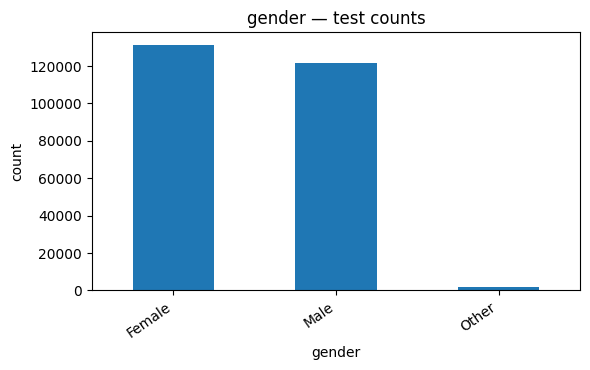

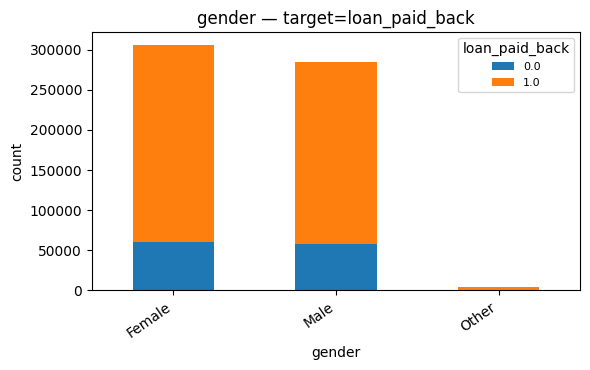

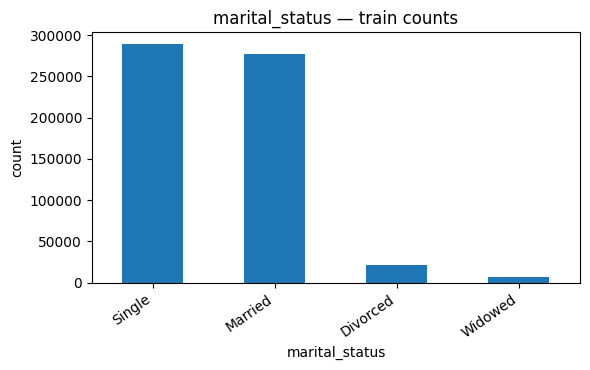

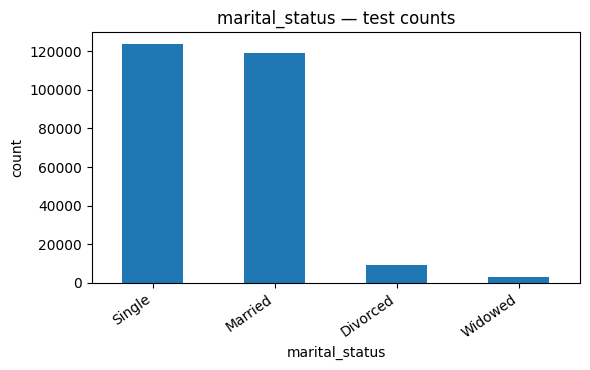

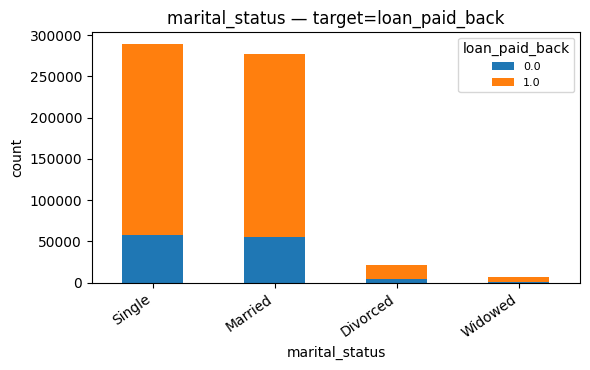

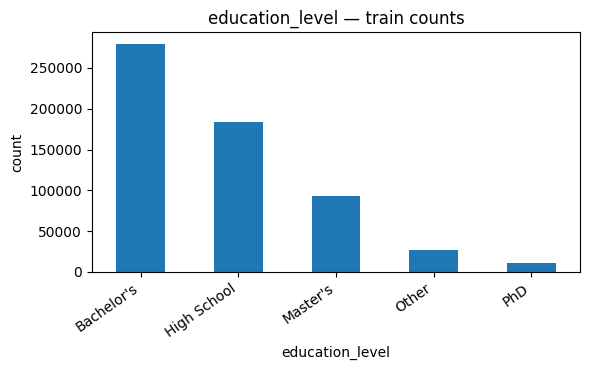

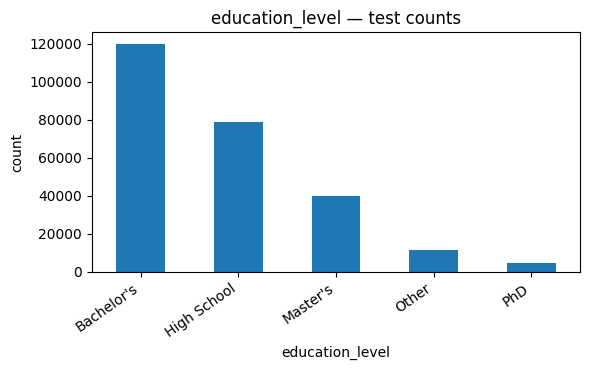

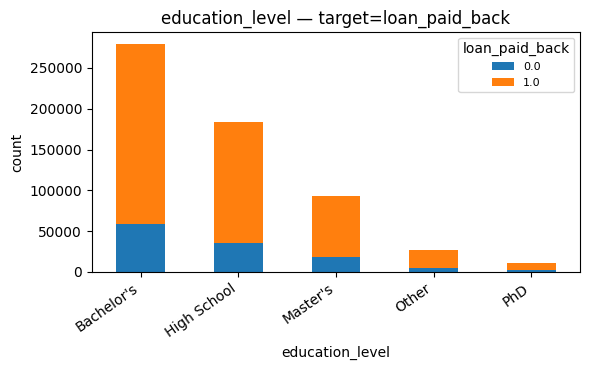

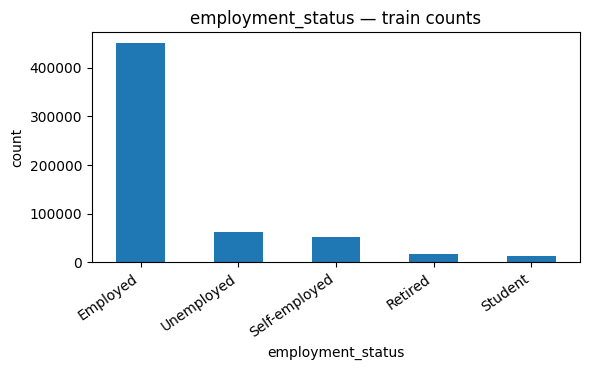

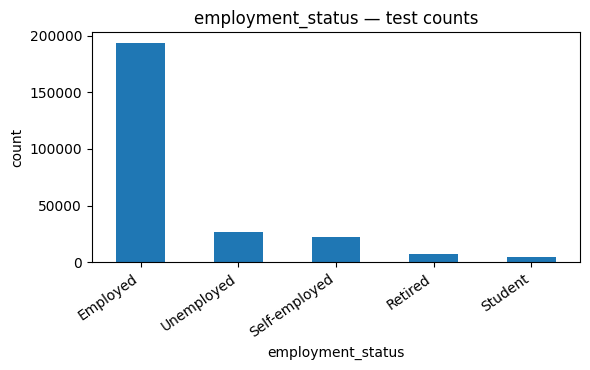

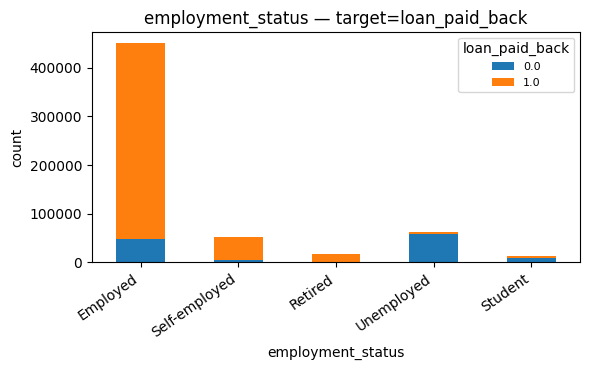

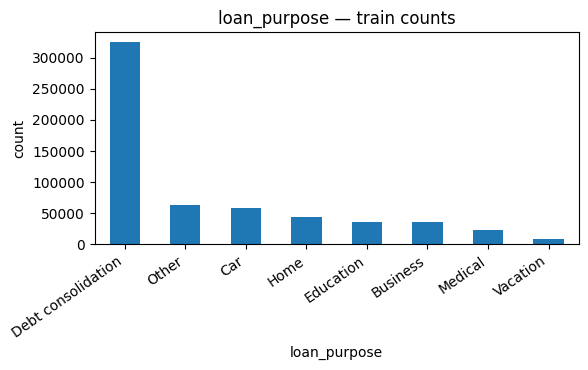

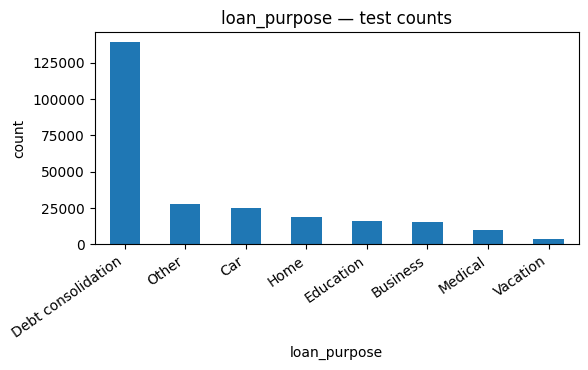

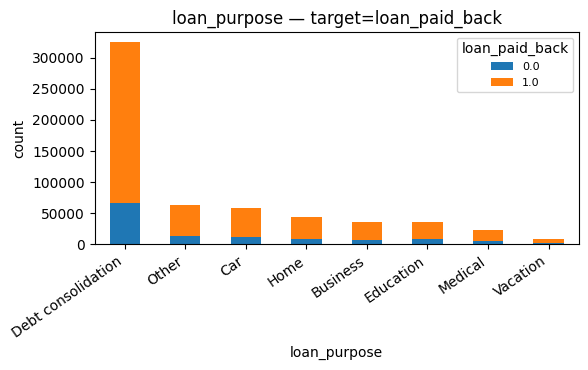

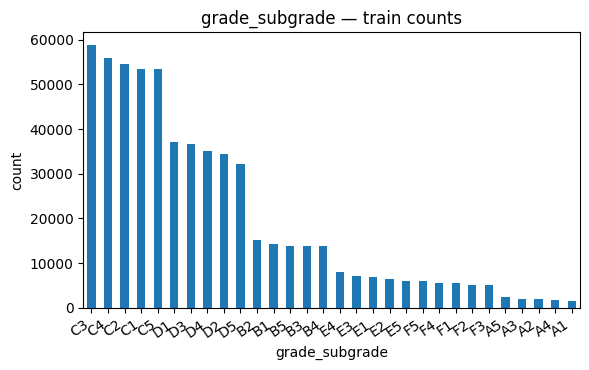

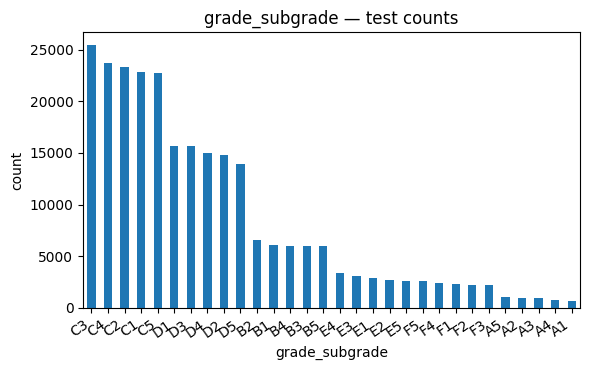

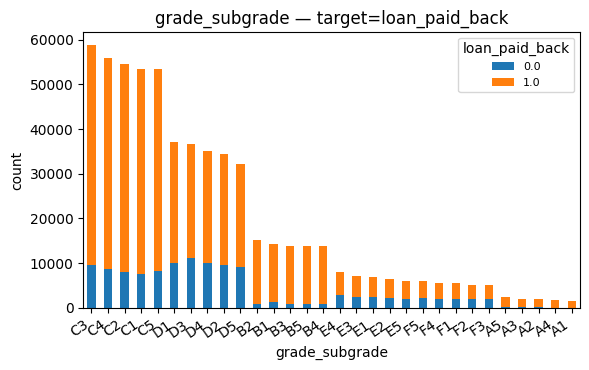

In [10]:
target_col = 'loan_paid_back'  # in this comp it's like that

for col in cat_feats:
    # 1) train counts
    vc_train = train[col].value_counts(dropna=False)
    plt.figure(figsize=(6, 3.8))
    vc_train.plot(kind='bar')
    plt.title(f'{col} — train counts')
    plt.ylabel('count')
    plt.xticks(rotation=35, ha='right')
    plt.tight_layout()
    plt.show()

    # 2) test counts (to see drift)
    vc_test = test[col].value_counts(dropna=False)
    plt.figure(figsize=(6, 3.8))
    vc_test.plot(kind='bar')
    plt.title(f'{col} — test counts')
    plt.ylabel('count')
    plt.xticks(rotation=35, ha='right')
    plt.tight_layout()
    plt.show()

    # 3) target split per category (only if target exists)
    if target_col in train.columns:
        ct = (
            train.groupby([col, target_col])
                 .size()
                 .unstack(fill_value=0)
                 .sort_values(by=list(train[target_col].unique()), ascending=False)
        )
        plt.figure(figsize=(6, 3.8))
        ct.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title(f'{col} — target={target_col}')
        plt.ylabel('count')
        plt.xticks(rotation=35, ha='right')
        plt.legend(title=target_col, fontsize=8)
        plt.tight_layout()
        plt.show()


In [11]:
corr=train[num_feats].corrwith(train['loan_paid_back'])

corr

id                      0.001387
annual_income           0.006326
debt_to_income_ratio   -0.335680
credit_score            0.234560
loan_amount            -0.003762
interest_rate          -0.131184
loan_paid_back          1.000000
dtype: float64

In [12]:
import pandas as pd

def cat_corr_with_binary(df: pd.DataFrame, cat_cols, target_col: str):
    scores = {}
    y = df[target_col]

    for col in cat_cols:
        # 1) mean target per category
        tgt_means = df.groupby(col)[target_col].mean()
        # 2) map back
        encoded = df[col].map(tgt_means)
        # 3) corr with target
        corr = encoded.corr(y)
        scores[col] = corr

    # return sorted series (abs to see strongest)
    s = pd.Series(scores).sort_values(key=lambda x: x.abs(), ascending=False)
    return s

# usage
cat_feats = train.select_dtypes(include='object').columns.tolist()
cat_corr = cat_corr_with_binary(train, cat_feats, 'loan_paid_back')
print(cat_corr)


employment_status    0.656824
grade_subgrade       0.227974
loan_purpose         0.025667
education_level      0.025407
gender               0.007432
marital_status       0.002634
dtype: float64


# Feature engineering

employment_status    0.656824
grade_subgrade       0.227974
loan_purpose         0.025667
education_level      0.025407


debt_to_income_ratio   -0.335680
credit_score            0.234560
loan_amount            -0.003762
interest_rate          -0.131184


In [13]:
'''
employment_status    0.656824
grade_subgrade       0.227974
loan_purpose         0.025667
education_level      0.025407
gender                                 0.007432
marital_status                         0.002634



debt_to_income_ratio   -0.335680
credit_score            0.234560
loan_amount            -0.003762
interest_rate          -0.131184
'''

def featurize(df):
    df['debt_to_income_ratio_square']=df['debt_to_income_ratio']**2
    df['credit_score_square']=df['credit_score']**2
    df['loan_amount_square']=df['loan_amount']**2
    df['interest_rate_square']=df['interest_rate']**2
    
    df['debt']=df['loan_amount']+ (df['loan_amount']* (df['interest_rate']/100))
    df['some_multi']=df['debt_to_income_ratio']*df['credit_score']
    df['debt_to_income_ratio_debt']=df['debt_to_income_ratio']* (1/df['debt'])
    df['loan_amount_debt_to_income_ratio']=df['loan_amount']*df['debt_to_income_ratio']
    #df['']=df['']*df['']

    df['credit_score_ratio_loan_amount']=df['credit_score']/df['loan_amount']
    df['credit_score_ratio_interest_rate']=df['credit_score']/df['interest_rate']


    df['ratio_some']=df['interest_rate']/df['loan_amount']




    df['debt_to_income_ratio_sqrt']=np.sqrt(df['debt_to_income_ratio'])
    df['interest_rate_sqrt']=np.sqrt(df['interest_rate'])
    df['loan_amount_sqrt']=np.sqrt(df['loan_amount'])
    df['credit_score_sqrt']=np.sqrt(df['credit_score'])

    



    df['employment_status_grade_subgrade']=df['employment_status']+ '_' + df['grade_subgrade']
    #df['grade_subgrade_interest_rate']=df['grade_subgrade']+ '_' + str(df['interest_rate'])
    df['loan_purpose_education_level']=df['loan_purpose']+'_' + df['education_level']
    #df['grade_subgrade_debt_to_income_ratio']=df['grade_subgrade']+ '_' + str(df['debt_to_income_ratio'])
    #df['credit_score_grade_subgrade']=str(df['credit_score'])+'_' + df['grade_subgrade']


    df['marital_status_employment_status']=df['marital_status']+'_'+df['employment_status']
    df['loan_purpose_marital_status']=df['loan_purpose']+'_'+df['marital_status']
    df['gender_marital_status']=df['gender']+'_'+df['marital_status']
    #df['']=df['']+'_'+df['']

    






    return df

In [14]:
train_full=featurize(train)

test_full=featurize(test)

In [15]:
train_full=train_full.drop(columns='id')
test_full=test_full.drop(columns='id')

In [16]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   annual_income                     593994 non-null  float64
 1   debt_to_income_ratio              593994 non-null  float64
 2   credit_score                      593994 non-null  int64  
 3   loan_amount                       593994 non-null  float64
 4   interest_rate                     593994 non-null  float64
 5   gender                            593994 non-null  object 
 6   marital_status                    593994 non-null  object 
 7   education_level                   593994 non-null  object 
 8   employment_status                 593994 non-null  object 
 9   loan_purpose                      593994 non-null  object 
 10  grade_subgrade                    593994 non-null  object 
 11  loan_paid_back                    593994 non-null  f

In [17]:
num_feats=train_full.select_dtypes(include='number').columns.tolist()
cat_feats=train_full.select_dtypes(include='object').columns.tolist()

In [18]:
corr=train_full[num_feats].corrwith(train_full['loan_paid_back'])

corr

annual_income                       0.006326
debt_to_income_ratio               -0.335680
credit_score                        0.234560
loan_amount                        -0.003762
interest_rate                      -0.131184
loan_paid_back                      1.000000
debt_to_income_ratio_square        -0.318558
credit_score_square                 0.233951
loan_amount_square                 -0.004025
interest_rate_square               -0.131434
debt                               -0.008862
some_multi                         -0.296570
debt_to_income_ratio_debt          -0.108359
loan_amount_debt_to_income_ratio   -0.245526
credit_score_ratio_loan_amount      0.013350
credit_score_ratio_interest_rate    0.174462
ratio_some                         -0.014290
debt_to_income_ratio_sqrt          -0.329317
interest_rate_sqrt                 -0.130240
loan_amount_sqrt                   -0.003149
credit_score_sqrt                   0.234474
dtype: float64

In [19]:
cat_feats = train_full.select_dtypes(include='object').columns.tolist()
cat_corr = cat_corr_with_binary(train, cat_feats, 'loan_paid_back')
print(cat_corr)


employment_status_grade_subgrade    0.681481
marital_status_employment_status    0.656848
employment_status                   0.656824
grade_subgrade                      0.227974
loan_purpose_education_level        0.036760
loan_purpose_marital_status         0.026674
loan_purpose                        0.025667
education_level                     0.025407
gender_marital_status               0.008094
gender                              0.007432
marital_status                      0.002634
dtype: float64


# Catboost

In [20]:
train.groupby('employment_status')['loan_paid_back'].mean().sort_values()
train['employment_status'].value_counts()

employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64

In [21]:
(
    train
    .groupby('employment_status')['loan_paid_back']
    .agg(['count', 'mean'])
    .sort_values('mean')
)


,count,mean
employment_status,,
Unemployed,62485,0.077619
Student,11931,0.263515
Employed,450645,0.894145
Self-employed,52480,0.898457
Retired,16453,0.997204


In [ ]:
for col in ['debt_to_income_ratio', 'credit_score', 'interest_rate']:
    grp_mean = train.groupby('employment_status')[col].transform('mean')
    train_full[f'{col}_emp_centered'] = train_full[col] - grp_mean

    # apply same to test
    emp_to_mean = train_full.groupby('employment_status')[col].mean().to_dict()
    test_full[f'{col}_emp_centered'] = (
        test_full.apply(lambda r: r[col] - emp_to_mean.get(r['employment_status'], train_full[col].mean()), axis=1)
    )


In [22]:
X=train_full.drop(columns='loan_paid_back')
y=train_full['loan_paid_back']

In [23]:
X_train, X_eval, y_train, y_eval=train_test_split(X, y, test_size=0.15, random_state=seed)

In [24]:
best_params = dict(
    loss_function='Logloss',
    eval_metric='AUC',
    task_type='GPU',
    random_seed=101,

    # capacity
    iterations=6000,          # we’ll stop earlier anyway
    learning_rate=0.03,       # slower than 0.05 → better AUC
    depth=8,                  # 6 → 8 gives more interactions

    # regularization
    l2_leaf_reg=4.0,
    random_strength=0.8,

    # bagging
    bootstrap_type='Bernoulli',
    subsample=0.8,

    # cats
    max_ctr_complexity=4,     # you make crosses, so don’t make it too big
    border_count=254,         # fine on GPU
    auto_class_weights='Balanced',
)

model = CatBoostClassifier(**best_params)

In [25]:
model.fit(X_train, y_train, eval_set=(X_eval, y_eval), cat_features=cat_feats, verbose=100, early_stopping_rounds=300)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9059901	best: 0.9059901 (0)	total: 8s	remaining: 13h 20m 1s
100:	test: 0.9121630	best: 0.9121630 (100)	total: 16s	remaining: 15m 37s
200:	test: 0.9137582	best: 0.9137582 (200)	total: 24.1s	remaining: 11m 34s
300:	test: 0.9145591	best: 0.9145603 (299)	total: 32s	remaining: 10m 5s
400:	test: 0.9151211	best: 0.9151211 (400)	total: 39.9s	remaining: 9m 17s
500:	test: 0.9156396	best: 0.9156396 (500)	total: 48.1s	remaining: 8m 47s
600:	test: 0.9160763	best: 0.9160763 (600)	total: 56.2s	remaining: 8m 25s
700:	test: 0.9163784	best: 0.9163784 (700)	total: 1m 4s	remaining: 8m 6s
800:	test: 0.9166310	best: 0.9166310 (800)	total: 1m 12s	remaining: 7m 51s
900:	test: 0.9169189	best: 0.9169192 (898)	total: 1m 20s	remaining: 7m 36s
1000:	test: 0.9171122	best: 0.9171134 (997)	total: 1m 28s	remaining: 7m 23s
1100:	test: 0.9174113	best: 0.9174113 (1100)	total: 1m 37s	remaining: 7m 11s
1200:	test: 0.9176310	best: 0.9176310 (1200)	total: 1m 45s	remaining: 7m
1300:	test: 0.9177517	best: 0.9177608 

In [26]:
importances = model.get_feature_importance()
for name, imp in zip(X_train.columns, importances):
    print(name, imp)

annual_income 2.8325451064428195
debt_to_income_ratio 4.539987418721865
credit_score 3.2488019553545104
loan_amount 0.704584962283098
interest_rate 1.2164762890593452
gender 0.6281991220040697
marital_status 0.4530746810254331
education_level 0.8518029827641915
employment_status 58.222061602858496
loan_purpose 0.6482530407222483
grade_subgrade 1.477118736864314
debt_to_income_ratio_square 4.690362390398122
credit_score_square 2.399262399311133
loan_amount_square 0.5377992788079321
interest_rate_square 0.4017228996517115
debt 0.627788213187305
some_multi 0.9746961375075758
debt_to_income_ratio_debt 1.1121154764425183
loan_amount_debt_to_income_ratio 1.0707800338410198
credit_score_ratio_loan_amount 0.8262380302691595
credit_score_ratio_interest_rate 1.3593443659679783
ratio_some 0.857287060576444
debt_to_income_ratio_sqrt 2.663114727175144
interest_rate_sqrt 0.42675741300029313
loan_amount_sqrt 0.3227022490655858
credit_score_sqrt 2.2760519347635357
employment_status_grade_subgrade 1.25

# Submission

In [27]:
probas = model.predict_proba(test_full)
p_pos = probas[:, 1]

In [28]:
sub=pd.DataFrame({
    'id': sample['id'],
    'loan_paid_back': p_pos
})

In [29]:
sub.to_csv('submission.csv', index=False)

# Meta models maybe?